## Introduction to visualizing data in the eeghdf files

### Getting started
The EEG is stored in hierachical data format (HDF5). This format is widely used, open, and supported in many languages, e.g., matlab, R, python, C, etc.

Here, I will use the h5py library in python

In [1]:
# import libraries
from __future__ import print_function, division, unicode_literals
%matplotlib inline
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from pprint import pprint

import stacklineplot # local copy

# matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
hdf = h5py.File('./archive/YA2741G2_1-1+.eeghdf')

The data is stored hierachically in an hdf5 file as a tree of keys and values.
It is possible to inspect the file using standard hdf5 tools.
Below we show the keys and values associated with the root of the tree. This shows that there is a "patient" group and a group "record-0"

In [3]:
list(hdf.items())

[('patient', <HDF5 group "/patient" (0 members)>),
 ('record-0', <HDF5 group "/record-0" (10 members)>)]

We can focus on the patient group and access it via hdf['patient'] as if it was a python dictionary. Here are the key,value pairs in that group. Note that the patient information has been anonymized. Everyone is given the same set of birthdays. This shows that this file is for Subject 2619, who is male.

In [4]:
list(hdf['patient'].attrs.items())

[('patient_name', '2619, Subject'),
 ('patientcode', '3fe61c07d97e5b5595d647f9c1dc469e'),
 ('gender', 'Male'),
 ('birthdate', '1990-01-01'),
 ('patient_additional', ''),
 ('gestatational_age_at_birth_days', -1.0),
 ('born_premature', 'unknown')]

Now we look at how the waveform data is stored. By convention, the first record is called "record-0" and it contains the waveform data as well as the approximate time (relative to the birthdate)at which the study was done, as well as technical information like the number of channels, electrode names and sample rate.

In [5]:
rec = hdf['record-0']
list(rec.attrs.items())

[('start_isodatetime', '2000-01-17 08:56:46'),
 ('end_isodatetime', '2000-01-17 09:26:57'),
 ('number_channels', 36),
 ('number_samples_per_channel', 362200),
 ('sample_frequency', 200.00000000000003),
 ('bits_per_sample', 16),
 ('technician', ''),
 ('patient_age_days', 3668.3727546296295)]

We can then grab the actual waveform data and visualize it.

In [6]:
signals = rec['signals']
labels = rec['signal_labels']
electrode_labels = [str(s,'ascii') for s in labels]
numbered_electrode_labels = ["%d:%s" % (ii, str(labels[ii], 'ascii')) for ii in range(len(labels))]

#### Simple visualization of EEG (brief absence seizure)

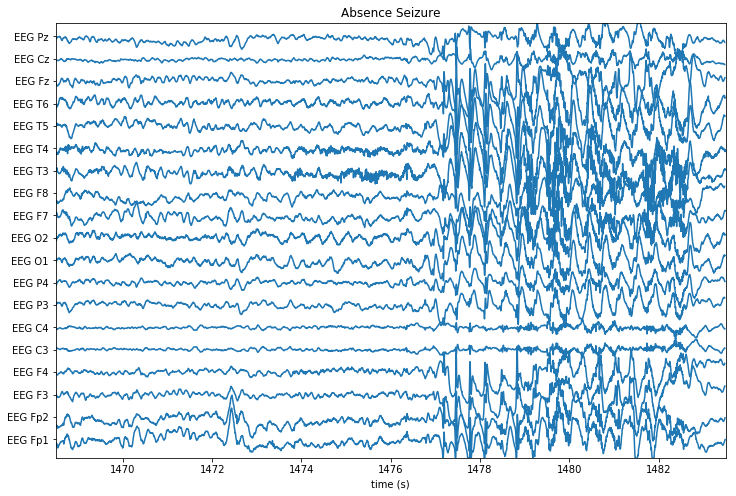

In [7]:
# search identified spasms at 1836, 1871, 1901, 1939
stacklineplot.show_epoch_centered(signals, 1476,epoch_width_sec=15,chstart=0, chstop=19, fs=rec.attrs['sample_frequency'], ylabels=electrode_labels, yscale=3.0)
plt.title('Absence Seizure');

### Annotations
It was not a coincidence that I chose this time in the record. I used the annotations to focus on portion of the record which was marked as having a seizure.

You can access the clinical annotations via rec['edf_annotations']

In [8]:
annot = rec['edf_annotations']

In [9]:
antext = [s.decode('utf-8') for s in annot['texts'][:]]
starts100ns = [xx for xx in annot['starts_100ns'][:]]  # process the bytes into text and lists of start times

In [10]:
df = pd.DataFrame(data=antext, columns=['text'])  # load into a pandas data frame
df['starts100ns'] = starts100ns
df['starts_sec'] = df['starts100ns']/10**7
del df['starts100ns']

It is easy then to find the annotations related to seizures

In [11]:
df[df.text.str.contains('sz',case=False)]

,text,starts_sec
86,SZ START,1380.512
88,SZ END,1384.246
91,SZ START,1416.897
93,SZ END,1422.843
99,SZ START,1476.933
103,SZ END,1483.269
